## Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('Datasets/8_comps.csv')
data.Price_change = data.Price_change.astype(int)
data_nn = data[['Positive', 'Negative', 'Neutral', 'Price_change']]
data_nn['Price_change'] = data_nn['Price_change'].apply(lambda x : x+1 if (x==-1) else x)
data_nn

C:\Users\Konpoul\AppData\Local\Temp/ipykernel_13408/3674252479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nn['Price_change'] = data_nn['Price_change'].apply(lambda x : x+1 if (x==-1) else x)


,Positive,Negative,Neutral,Price_change
0,0.046127,0.411465,0.542409,0
1,0.070845,0.449025,0.480130,1
2,0.190995,0.453761,0.355244,0
3,0.204221,0.447518,0.348261,0
4,0.315863,0.218127,0.466010,1
...,...,...,...,...
3843,0.243090,0.565334,0.191576,0
3844,0.173455,0.011468,0.815077,0
3845,0.033993,0.045346,0.920662,1
3846,0.953540,0.023839,0.022620,1


In [18]:
subs = data_nn.sample(frac=0.4)
train_dataframe = data_nn.drop(subs.index)
val_dataframe = subs.sample(frac=0.5)
test_dataframe = subs.drop(val_dataframe.index)

In [19]:
print("Train",train_dataframe.shape)
print("Val",val_dataframe.shape)
print("Test",test_dataframe.shape)

Train (2309, 4)
Val (770, 4)
Test (769, 4)


In [20]:
def dataframe_to_dataset(dataframe):
    df = dataframe.copy()
    labels = df.pop("Price_change")
    labels = to_categorical(labels, 2)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

In [21]:
train_ds

<ShuffleDataset shapes: ({Positive: (), Negative: (), Neutral: ()}, (2,)), types: ({Positive: tf.float64, Negative: tf.float64, Neutral: tf.float64}, tf.float32)>

In [22]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'Positive': <tf.Tensor: shape=(), dtype=float64, numpy=0.0824782717972993>, 'Negative': <tf.Tensor: shape=(), dtype=float64, numpy=0.0640145596116781>, 'Neutral': <tf.Tensor: shape=(), dtype=float64, numpy=0.8535071015357971>}
Target: tf.Tensor([1. 0.], shape=(2,), dtype=float32)


In [23]:
# batch the datasets into batches of 32 data-points
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [24]:
from tensorflow.keras.layers import Normalization
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

In [25]:
positive = keras.Input(shape=(1,), name="Positive")
negative = keras.Input(shape=(1,), name="Negative")
neutral = keras.Input(shape=(1,), name="Neutral")

positive_enc = encode_numerical_feature(positive, 'Positive', train_ds)
negative_enc = encode_numerical_feature(negative, 'Negative', train_ds)
neutral_enc = encode_numerical_feature(neutral, 'Neutral', train_ds)

inputs = [positive, negative, neutral ]
features = layers.concatenate( [positive_enc, negative_enc, neutral_enc] )

### Define FNN Model 

In [26]:
# MODEL 1
# Fully vonnected layer with 3 inputs (features tensors) and 32 neurons/outuputs.
x = layers.Dense(32, activation="relu")(features)
x = layers.Dropout(0.2)(x) # add a dropout for less overfitting
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, output)
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [27]:
# MODEL 2
# Fully vonnected layer with 3 inputs (features tensors) and 32 neurons/outuputs.
x = layers.Dense(512, activation="relu")(features)
x = layers.Dropout(0.2)(x) # add a dropout for less overfitting
x = layers.Dense(1024, activation="relu")(features)
x = layers.Dropout(0.2)(x) # add a dropout for less overfitting
x = layers.Dense(1024, activation="relu")(features)
x = layers.Dropout(0.2)(x) # add a dropout for less overfitting
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(2, activation="softmax")(x)
model2 = keras.Model(inputs, output)
model2.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

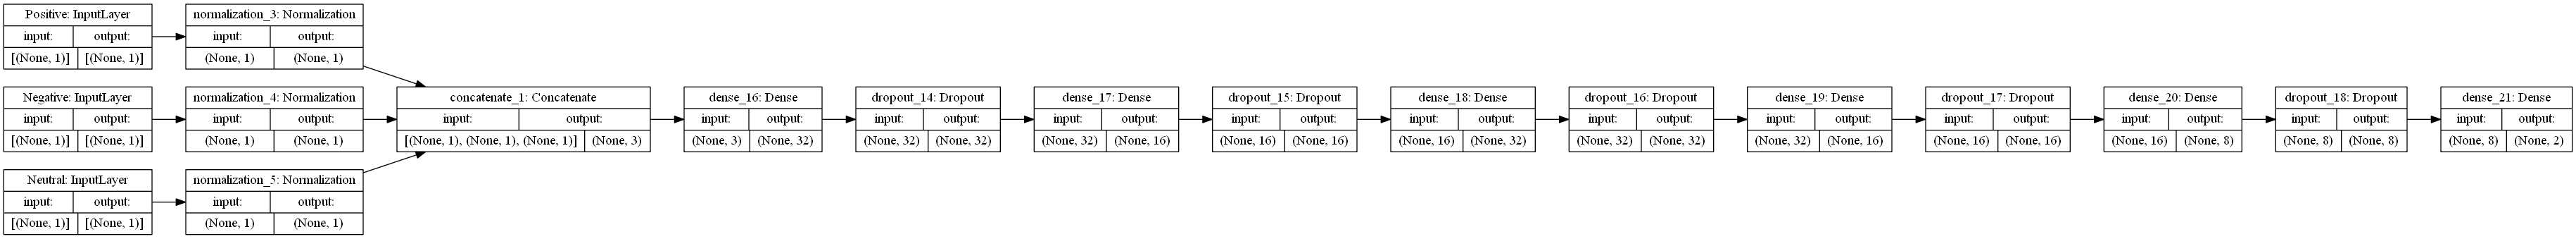

In [28]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Callbacks and train helpers

In [29]:
def assign_callbacks(weights_file,patience,lr_factor):
  return[
      #Only save the weights that correspond to the minimum validation loss.
      tf.keras.callbacks.ModelCheckpoint(filepath=weights_file,
                                         monitor='val_accuracy',
                                         mode='max',
                                         save_best_only=True ,
                                         save_weights_only=True,
                                         verbose=0),
      #If val_loss doesn't improve for a number of epochs set with 'patience' 
      #variable, training will stop to avoid overfitting.    
      tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                       mode='min',
                                       patience=patience,
                                       verbose=1),
      #Learning rate is reduced by 'lr_factor' if val_loss stagnates
      #for a number of epochs set with 'patience/2' variable.
      tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                           mode='min',
                                           factor=lr_factor,
                                           patience=patience//2,
                                           min_lr=1e-6,
                                           verbose=1)]



In [30]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

### Train

In [31]:
# used in the training loop
weights_file = 'Neural_Net1'
patience = 10
lr = 0.001
callbacks = assign_callbacks(weights_file, 10, lr)

history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=callbacks)

Epoch 1/100
73/73 [==============================] - 1s 8ms/step - loss: 0.6863 - accuracy: 0.5275 - val_loss: 0.6830 - val_accuracy: 0.5169
Epoch 2/100
73/73 [==============================] - 0s 3ms/step - loss: 0.6882 - accuracy: 0.5154 - val_loss: 0.6821 - val_accuracy: 0.5623
Epoch 3/100
73/73 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5453 - val_loss: 0.6792 - val_accuracy: 0.5610
Epoch 4/100
73/73 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5574 - val_loss: 0.6776 - val_accuracy: 0.5662
Epoch 5/100
73/73 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5522 - val_loss: 0.6757 - val_accuracy: 0.5662
Epoch 6/100
73/73 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.5751 - val_loss: 0.6775 - val_accuracy: 0.5688
Epoch 7/100
73/73 [==============================] - 0s 4ms/step - loss: 0.6766 - accuracy: 0.5461 - val_loss: 0.6765 - val_accuracy: 0.5662
Epoch 8/100
7

In [ ]:
visualize_loss(history, "Training and Validation Loss")

In [ ]:
# used in the training loop
weights_file = 'Neural_Net2'
patience = 10
lr = 0.0001
callbacks = assign_callbacks(weights_file, 10, lr)

history2 = model2.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=callbacks)

In [ ]:
visualize_loss(history2, "Training and Validation Loss")

### Predicting on the test set

In [ ]:
def denormalise(values):
    # Some functions need 1-d arrays
    # This function transform n-dimensional y to 1-d y
    y_den = []
    for dist in values:
        y_den.append(np.argmax(dist))
        
    return y_den

In [ ]:
test_labels = []
for x, y in test_ds.take(len(test_ds)):
    test_labels.append(y)
test_labels = denormalise(test_labels)

#### Predictions of Model1

In [ ]:
# load optimal weights computed during training
model.load_weights('Neural_Net1')

from sklearn.metrics import f1_score, accuracy_score

preds = model.predict(test_ds)
preds =  denormalise(preds)
# Make precictions on test set and print model's accuracy.
f1 = f1_score(test_labels, 
              preds,
              average='micro')
print("F1 micro on test set is :", f1)


acc = accuracy_score(test_labels, 
                     preds)
print("Accuracy on test set is :", acc)

# Confusion Matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2])
disp.plot()
plt.show()

#### Predictions of Model2

In [ ]:
# load optimal weights computed during training
model2.load_weights('Neural_Net2')

from sklearn.metrics import f1_score, accuracy_score

preds = model2.predict(test_ds)
preds =  denormalise(preds)
# Make precictions on test set and print model's accuracy.
f1 = f1_score(test_labels, 
              preds,
              average='micro')
print("F1 micro on test set is :", f1)


acc = accuracy_score(test_labels, 
                     preds)
print("Accuracy on test set is :", acc)

# Confusion Matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2])
disp.plot()
plt.show()